In [1]:
import warnings

warnings.filterwarnings("ignore", ".*does not have many workers.*")
warnings.filterwarnings("ignore", category=FutureWarning)

import time
import os
from pathlib import Path
from os import environ
import pytorch_lightning as pl
import torch
from bicycle.dictlogger import DictLogger
from bicycle.model import BICYCLE
from bicycle.utils.data import (
    create_data,
    create_loaders,
    get_diagonal_mask,
    compute_inits,
)
from bicycle.utils.general import get_full_name
from bicycle.utils.plotting import plot_training_results
from pytorch_lightning.callbacks import RichProgressBar, StochasticWeightAveraging
from bicycle.callbacks import ModelCheckpoint, GenerateCallback, MyLoggerCallback, CustomModelCheckpoint
import numpy as np
import yaml
from pytorch_lightning.tuner.tuning import Tuner

n_factors = 0

add_covariates = False
n_covariates =  0 # Number of covariates
covariate_strength = 5.0
correct_covariates = False

intervention_type_simulation = "Cas9"
intervention_type_inference = "Cas9"

SEED = 1
pl.seed_everything(SEED)
torch.set_float32_matmul_precision("high")
device = torch.device("cpu")
if environ["USER"] == "m015k":
    user_dir = "/home/m015k/code/bicycle/notebooks/data"
else:
    user_dir = "."
MODEL_PATH = Path(os.path.join(user_dir, "models"))
PLOT_PATH = Path(os.path.join(user_dir, "plots"))
MODEL_PATH.mkdir(parents=True, exist_ok=True)
PLOT_PATH.mkdir(parents=True, exist_ok=True)

#
# Settings
#

# DATA GENERATION
n_genes = 10  # Number of modelled genes
rank_w_cov_factor = n_genes  # Same as dictys: #min(TFs, N_GENES-1)
graph_type = "erdos-renyi"
edge_assignment = "random-uniform"
sem = "linear-ou"
graph_kwargs = {
    "abs_weight_low": 0.25,
    "abs_weight_high": 0.95,
    "p_success": 0.5,
    "expected_density": 2,
    "noise_scale": 0.5,
    "intervention_scale": 0.1,
}
n_additional_entries = 12
n_contexts = n_genes + 1  # Number of contexts
n_samples_control = 500
n_samples_per_perturbation = 250
perfect_interventions = True
make_contractive = True
make_counts = True
synthetic_T  = 1.0
library_size_range = [10*n_genes, 100*n_genes]

# TRAINING
lr = 1e-3 #3e-4
batch_size = 1_000
USE_INITS = False
use_encoder = False
n_epochs = 11000
early_stopping = False
early_stopping_patience = 500
early_stopping_min_delta = 0.01
# Maybe this helps to stop the loss from growing late during training (see current version
# of Plot_Diagnostics.ipynb)
optimizer = "adam" #"rmsprop" #"adam"
optimizer_kwargs = {
    "betas": [0.5,0.9] # Faster decay for estimates of gradient and gradient squared
}
gradient_clip_val = 1.0
GPU_DEVICE = 0
plot_epoch_callback = 500
validation_size = 0.2
lyapunov_penalty = True
swa = 250
n_epochs_pretrain_latents = 1000

LOGO = []
train_gene_ko = [str(x) for x in set(range(0, n_genes)) - set(LOGO)]  # We start counting at 0
# FIXME: There might be duplicates...
ho_perturbations = sorted(
    list(set([tuple(sorted(np.random.choice(n_genes, 2, replace=False))) for _ in range(0, 20)]))
)
test_gene_ko = [f"{x[0]},{x[1]}" for x in ho_perturbations]

# MODEL
x_distribution = "Multinomial"
x_distribution_kwargs = {}
model_T = 1.0
learn_T = False
use_latents = make_counts

# RESULTS
name_prefix = f"LATENT_SYNTHETIC_optim{optimizer}_b1_0.5_b2_0.9_pretrain_epochs{n_epochs_pretrain_latents}synthetic_T{synthetic_T}_GRAD-CLIP_SIM:{intervention_type_simulation}INF:{intervention_type_inference}-slow_lr_{graph_type}_{edge_assignment}_{use_encoder}_{batch_size}_{lyapunov_penalty}"
SAVE_PLOT = True
CHECKPOINTING = False
VERBOSE_CHECKPOINTING = False
OVERWRITE = True
# REST
n_samples_total = n_samples_control + (len(train_gene_ko) + len(test_gene_ko)) * n_samples_per_perturbation
check_val_every_n_epoch = 1
log_every_n_steps = 1


# Create Mask
mask = get_diagonal_mask(n_genes, device)

if n_factors > 0:
    mask = None

#
# Create synthetic data
#
gt_dyn, intervened_variables, samples, gt_interv, sim_regime, beta = create_data(
    n_genes,
    n_samples_control=n_samples_control,
    n_samples_per_perturbation=n_samples_per_perturbation,
    device=device,
    make_counts=make_counts,
    T = synthetic_T,
    train_gene_ko=train_gene_ko,
    test_gene_ko=test_gene_ko,
    graph_type=graph_type,
    edge_assignment=edge_assignment,
    sem=sem,
    make_contractive=make_contractive,
    intervention_type = intervention_type_simulation,
    library_size_range = library_size_range,
    **graph_kwargs,
)

check_samples, check_gt_interv, check_sim_regime, check_beta = (
        np.copy(samples), np.copy(gt_interv), np.copy(sim_regime), np.copy(beta)
)

print("eigvals B:",torch.max(torch.real(torch.linalg.eigvals(beta - torch.eye(n_genes)))))

if add_covariates:
    
    print('ADDING COVARIATES')
    # Create some artificial covariates and add them to the simulated data
    covariates = torch.randn((n_samples_total, n_covariates)).to(device)
    covariate_weights = torch.zeros((n_genes, n_covariates)).to(device)
    
    '''covariate_weights[0,0] = covariate_strength
    covariate_weights[1,0] = covariate_strength
    
    covariate_weights[2,1] = -covariate_strength
    covariate_weights[3,1] = covariate_strength
    
    covariate_weights[4,2] = covariate_strength
    covariate_weights[5,2] = covariate_strength
    covariate_weights[6,2] = -covariate_strength'''
    
    covariate_weights[:,0] = covariate_strength
    
    print('covariates.shape',covariates.shape)
    print('covariate_weights',covariate_weights)
    
    print('samples before:',samples[:2])
    
    samples = samples + torch.mm(covariates, covariate_weights.transpose(0,1)) 
    
    print('samples after:',samples[:2])
    
    train_loader, validation_loader, test_loader, covariates = create_loaders(
        samples,
        sim_regime,
        validation_size,
        batch_size,
        SEED,
        train_gene_ko,
        test_gene_ko,
        covariates = covariates
    )
    
    if correct_covariates == False:
        print('NOT CORRECTING FOR COVARIATES!')
        covariates = None
    
else:
    
    train_loader, validation_loader, test_loader = create_loaders(
        samples,
        sim_regime,
        validation_size,
        batch_size,
        SEED,
        train_gene_ko,
        test_gene_ko
    )
    
    covariates = None

if USE_INITS:
    init_tensors = compute_inits(train_loader.dataset, rank_w_cov_factor, n_contexts)

print("Training data:")
print(f"- Number of training samples: {len(train_loader.dataset)}")
if validation_size > 0:
    print(f"- Number of validation samples: {len(validation_loader.dataset)}")
if LOGO:
    print(f"- Number of test samples: {len(test_loader.dataset)}")

device = torch.device(f"cuda:{GPU_DEVICE}")
gt_interv = gt_interv.to(device)
n_genes = samples.shape[1]

[rank: 0] Global seed set to 1


Simulating data of intervention type Cas9
Shapes Cas9: torch.Size([30, 10, 10]) torch.Size([30, 10]) torch.Size([30, 10, 10])


  0%|          | 0/7750 [00:00<?, ?it/s]

eigvals B: tensor(-0.6347)
Training data:
- Number of training samples: 7750
- Number of validation samples: 600


In [4]:
from bicycle.model import BICYCLE

filename = "/g/stegle/ueltzhoe/PMBio/bicycle/notebooks/experiments/synthetic/models/LATENT_SYNTHETIC_optimadam_b1_0.5_b2_0.9_pretrain_epochs1000synthetic_T1.0_GRAD-CLIP_SIM:Cas9INF:Cas9-slow_lr_erdos-renyi_random-uniform_False_1000_True_0_1_0.001_10_0.5_1.0_0.0_1.0_1.0_250/epoch=1578-valid_loss=3.08.ckpt"

eval_model = BICYCLE.load_from_checkpoint(checkpoint_path=filename, strict=True)

# Predicts means for conditions, for which only the alpha_p and sigma_p parameters, modeling the MARGINAL DISTRIBUTION 
# of the direct perturbation target genes were optimized.

# TODO: Implement additional option to either specify or infer/predict these marginal distributions to predict unseen
# activation/knock-down/knock-out interventions from similar training interventions on different target genes.

# eval_model.predict_means(regimes = [0,1])

In [8]:
pred_percentages = eval_model.predict_mean_percentages(test_loader.dataset[:])#[:100])
pred_percentages.min(), pred_percentages.mean(), pred_percentages.max()

(tensor(0.0435, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(0.1000, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.2618, device='cuda:0', grad_fn=<MaxBackward1>))

In [7]:
test_samples, test_regimes, _, _ = test_loader.dataset[:]

test_regimes.unique()

tensor([11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28,
        29])

In [9]:
test_samples, test_regimes, _, _ = test_loader.dataset[:]

# Exclude test samples, which do not have any counts in the selected genes
test_sample_idx = test_samples.sum(axis = 1) > 0.5
test_samples = test_samples[test_sample_idx]
test_regimes = test_regimes[test_sample_idx]
pred_percentages = pred_percentages[test_sample_idx]

test_percentages = test_samples / test_samples.sum(axis = 1, keepdims = True)
test_percentages.min(), test_percentages.mean(), test_percentages.max()

(tensor(0.), tensor(0.1000), tensor(0.4010))

In [15]:
test_conditions = test_regimes.unique()
test_conditions

test_means = np.zeros( (len(test_conditions),test_percentages.shape[1]) )
pred_means = np.zeros( (len(test_conditions),pred_percentages.shape[1]) )
for i, cond in enumerate(test_conditions):
    idx = test_regimes == cond
    print('Condition:', cond.item(), 'Samples:', idx.sum())
    pred_means[i] = pred_percentages[idx].detach().cpu().numpy().mean(axis = 0, keepdims = True)
    test_means[i] = test_percentages[idx].detach().cpu().numpy().mean(axis = 0, keepdims = True)

print(pred_means.max())
print(test_means.max())

Condition: 11 Samples: tensor(250)
Condition: 12 Samples: tensor(250)
Condition: 13 Samples: tensor(250)
Condition: 14 Samples: tensor(250)
Condition: 15 Samples: tensor(250)
Condition: 16 Samples: tensor(250)
Condition: 17 Samples: tensor(250)
Condition: 18 Samples: tensor(250)
Condition: 19 Samples: tensor(250)
Condition: 20 Samples: tensor(250)
Condition: 21 Samples: tensor(250)
Condition: 22 Samples: tensor(250)
Condition: 23 Samples: tensor(250)
Condition: 24 Samples: tensor(250)
Condition: 25 Samples: tensor(250)
Condition: 26 Samples: tensor(250)
Condition: 27 Samples: tensor(250)
Condition: 28 Samples: tensor(250)
Condition: 29 Samples: tensor(250)
0.2617521286010742
0.2638857364654541


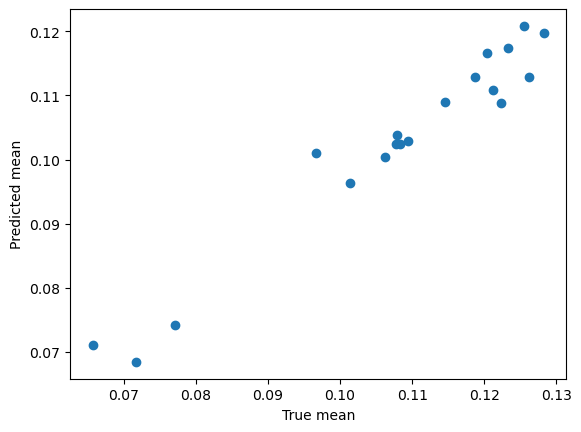

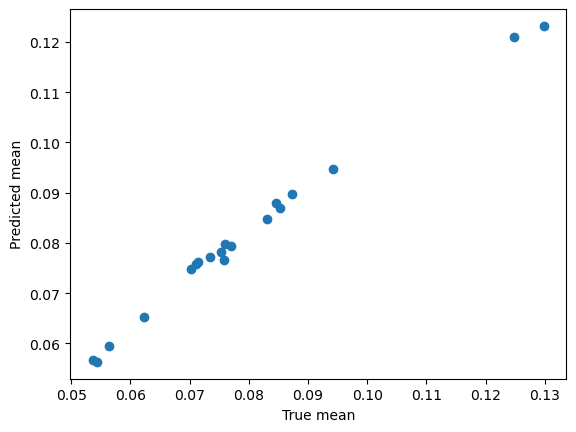

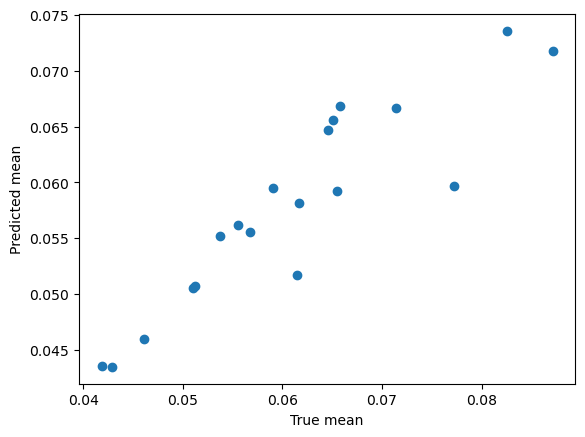

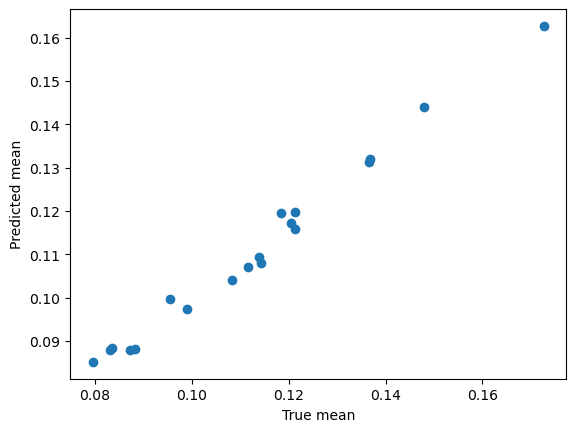

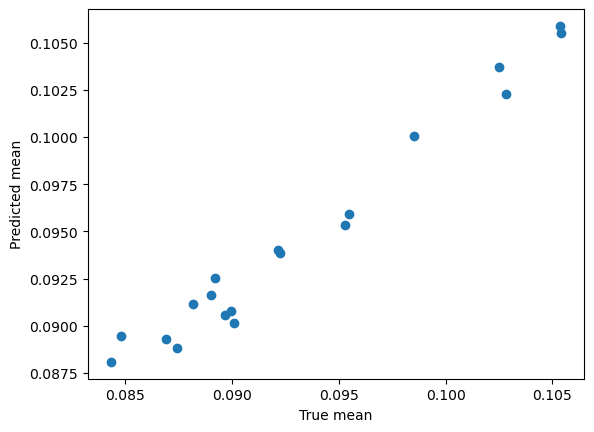

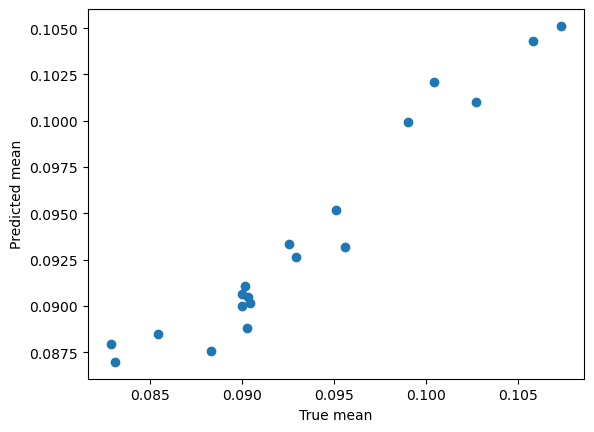

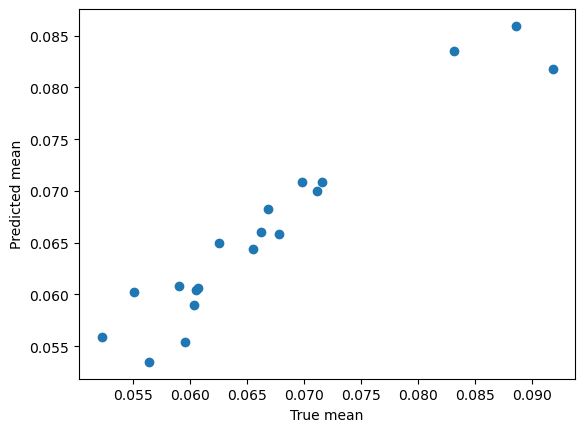

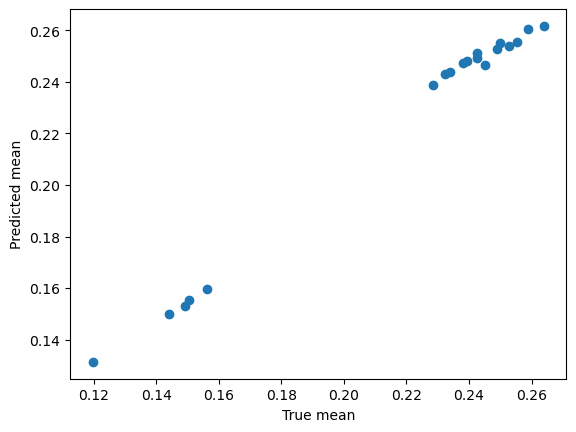

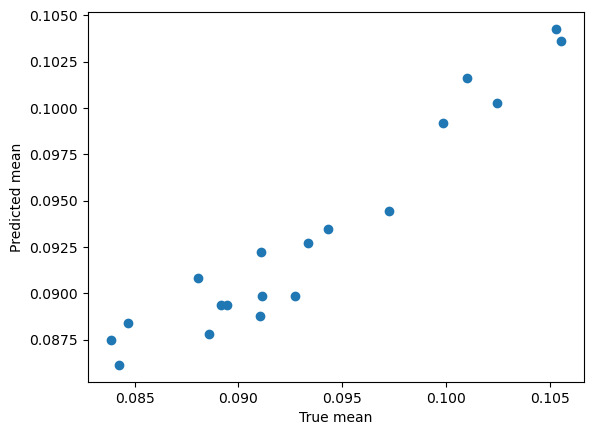

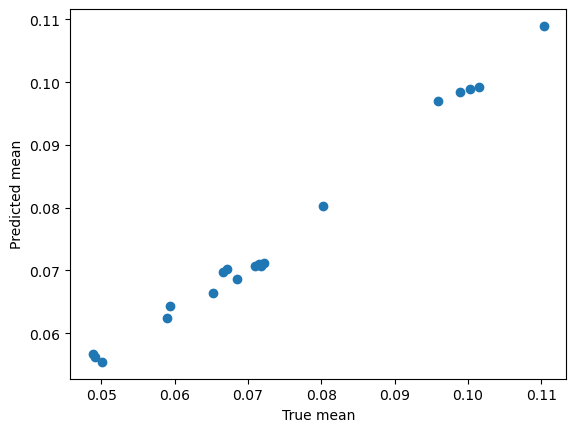

In [13]:
import matplotlib.pyplot as plt

for gene in range(n_genes):
    plt.figure()
    plt.scatter(test_means[:,gene],pred_means[:,gene])
    plt.xlabel('True mean')
    plt.ylabel('Predicted mean')
    plt.show()